In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
sns.set(style="darkgrid")

Here, we are again creating the dataset:

In [3]:
# create batting average dataset (sum over years)
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
pitching = pitching.groupby("playerID").agg({"G": "sum"})
# create batting average dataset (sum over years)
batting = pd.read_csv("~/baseball/core/Batting.csv")
pitching = pd.read_csv("~/baseball/core/Pitching.csv")
pitching = pitching.groupby("playerID").agg({"G": "sum"}).reset_index()
pitching = pitching.loc[pitching["G"]>3]
# filter pitchers with 4+ games
batting_pitchers = batting.playerID.isin(pitching.playerID)
batting = batting[~batting_pitchers]
# sum over seasons
batting = batting.loc[batting["AB"] > 0].groupby("playerID").agg({"AB": "sum", "H": "sum"})
batting["average"] = batting["H"]/batting["AB"]
# add actual player name
people = pd.read_csv("~/baseball/core/People.csv")
people["name"] = people["nameFirst"] + " " + people["nameLast"]
batting = batting.merge(people[["playerID", "name"]], on="playerID")
# I am using the book values here, not the values that we got in our last notebook. I think the difference comes
# from the fact that we are using more data (data from more recent seasons).
alpha_0 = 101.4
beta_0 = 287.3
# add empirical Bayes estimate
# this is called a point estimate
batting["eb_estimate"] = (batting["H"] + alpha_0) / (batting["AB"] + alpha_0 + beta_0)
batting["alpha_1"] = alpha_0 + batting["H"]
batting["beta_1"] = beta_0 + batting["AB"] - batting["H"]
# sort by eb_estimate
batting = batting.sort_values("eb_estimate", ascending=False)

We are going to use MCMC (Markov chain Monte Carlo) to estimate the parameters of our Beta Binomial model. This will take much longer than the maximum likelihood estimation, but with the right priors, it will be much more stable.

Good reading: http://sl8r000.github.io/ab_testing_statistics/use_a_hierarchical_model/
https://twiecki.io/blog/2014/03/17/bayesian-glms-3/
https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

Just for fun, let's just do a normal Beta Binomial estimation:

In [ ]:
from scipy.stats import binom, beta
AB = np.array(batting["AB"])
H = np.array(batting["H"])

with pm.Model() as model0:
    alpha0 = pm.Uniform('alpha', 50, 150)
    beta0 = pm.Uniform('beta', 200, 300)
    X0 = pm.BetaBinomial('X', alpha=alpha0, beta=beta0, n=AB, observed=H)
    trace0 = pm.sample(75000, step=pm.Metropolis(vars=[alpha0, beta0, X0]))

In [18]:
pm.summary(trace0)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,73.922561,3.990804,0.390602,68.410020,81.364172,20.589332,1.001083
beta,220.787454,11.643177,1.139930,204.592859,242.509337,20.566531,1.001056


We can now look at the traces and check out the estimates:

In [26]:
alpha_0_samples = trace0["alpha"][5000:75000, None]
beta_0_samples = trace0["beta"][5000:75000, None]

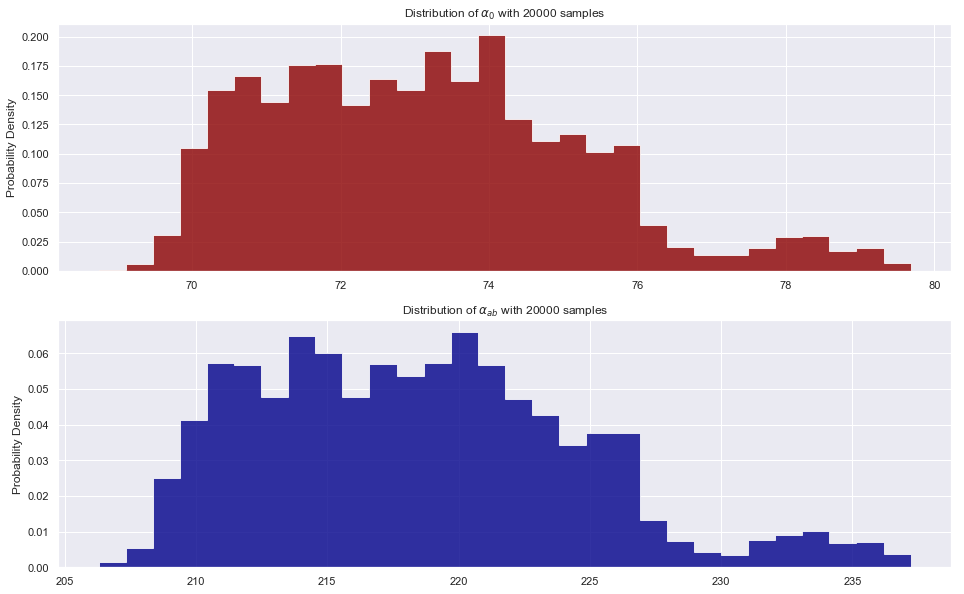

In [27]:
from IPython.core.pylabtools import figsize
figsize(16, 10)

plt.subplot(211)
plt.title(r"""Distribution of $\alpha_0$ with %d samples""" % 20000)

plt.hist(alpha_0_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(212)
plt.title(r"""Distribution of $\alpha_{ab}$ with %d samples""" % 20000)
plt.hist(beta_0_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

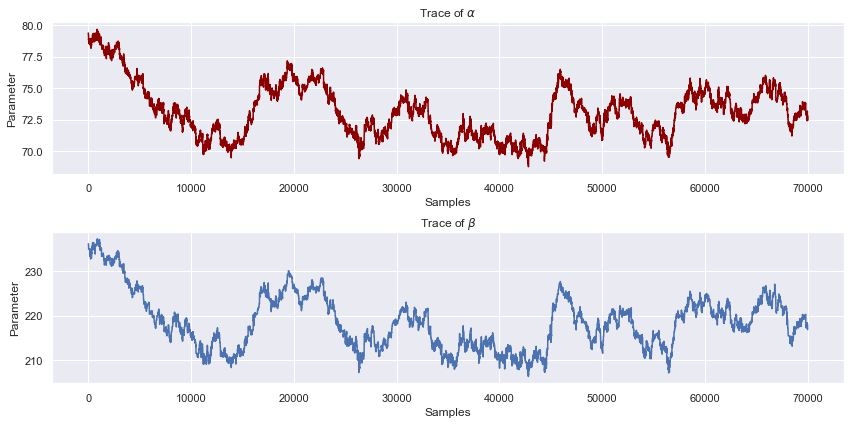

In [28]:
figsize(12, 6)

# Plot alpha trace
plt.subplot(211)
plt.title(r'Trace of $\alpha$')
plt.plot(alpha_0_samples, color = 'darkred')
plt.xlabel('Samples'); plt.ylabel('Parameter');

# Plot beta trace
plt.subplot(212)
plt.title(r'Trace of $\beta$')
plt.plot(beta_0_samples, color='b')
plt.xlabel('Samples'); plt.ylabel('Parameter');
plt.tight_layout(h_pad=0.8)

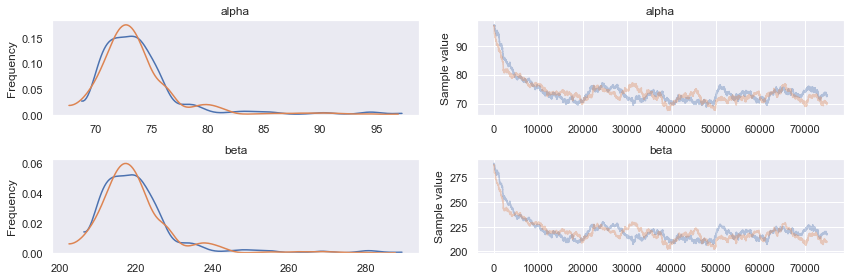

In [29]:
figsize(20, 12)
pm.traceplot(trace0, ['alpha', 'beta']);

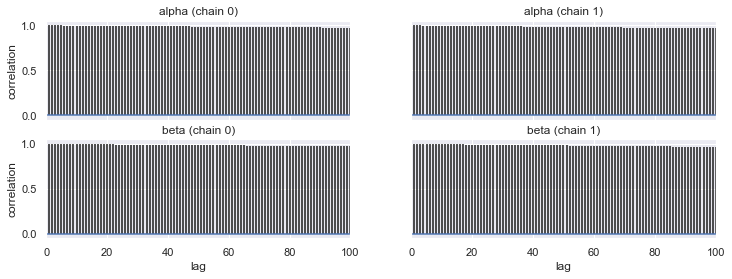

In [30]:
pm.autocorrplot(trace0, ['alpha', 'beta']);

This was my attempt to create a BetaBinomialTrend class:

In [31]:
import numpy as np
import theano.tensor as tt
import theano
from scipy import stats
import warnings
import math

from pymc3.util import get_variable_name
from pymc3.distributions.dist_math import bound, factln, binomln, betaln, logpow, random_choice
from pymc3.distributions.distribution import Discrete, draw_values, generate_samples
from pymc3.math import tround, sigmoid, logaddexp, logit, log1pexp

def floatX(X):
    """
    Convert a theano tensor or numpy array to theano.config.floatX type.
    """
    try:
        return X.astype(theano.config.floatX)
    except AttributeError:
        # Scalar passed
        return np.asarray(X, dtype=theano.config.floatX)


_conversion_map = {'float64': 'int32',
                   'float32': 'int16',
                   'float16': 'int8',
                   'float8': 'int8'}


def intX(X):
    """
    Convert a theano tensor or numpy array to theano.tensor.int32 type.
    """
    intX = _conversion_map[theano.config.floatX]
    try:
        return X.astype(intX)
    except AttributeError:
        # Scalar passed
        return np.asarray(X, dtype=intX)



class BetaBinomialTrend(Discrete):
    R"""
    Beta-binomial log-likelihood.
    Equivalent to binomial random variable with success probability
    drawn from a beta distribution.
    The pmf of this distribution is
    .. math::
       f(x \mid \alpha, \beta, n) =
           \binom{n}{x}
           \frac{B(x + \alpha, n - x + \beta)}{B(\alpha, \beta)}
    .. plot::
        import matplotlib.pyplot as plt
        import numpy as np
        import scipy.stats as st
        from scipy import special
        plt.style.use('seaborn-darkgrid')
        def BetaBinom(a, b, n, x):
            pmf = special.binom(n, x) * (special.beta(x+a, n-x+b) / special.beta(a, b))
            return pmf
        x = np.arange(0, 11)
        alphas = [0.5, 1, 2.3]
        betas = [0.5, 1, 2]
        n = 10
        for a, b in zip(alphas, betas):
            pmf = BetaBinom(a, b, n, x)
            plt.plot(x, pmf, '-o', label=r'$\alpha$ = {}, $\beta$ = {}, n = {}'.format(a, b, n))
        plt.xlabel('x', fontsize=12)
        plt.ylabel('f(x)', fontsize=12)
        plt.ylim(0)
        plt.legend(loc=9)
        plt.show()
    ========  =================================================================
    Support   :math:`x \in \{0, 1, \ldots, n\}`
    Mean      :math:`n \dfrac{\alpha}{\alpha + \beta}`
    Variance  :math:`n \dfrac{\alpha \beta}{(\alpha+\beta)^2 (\alpha+\beta+1)}`
    ========  =================================================================
    Parameters
    ----------
    n : int
        Number of Bernoulli trials (n >= 0).
    alpha : float
        alpha > 0.
    beta : float
        beta > 0.
    """

    def __init__(self, alpha_0, alpha_ab, sigma, n, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha_0 = alpha_0 = tt.as_tensor_variable(floatX(alpha_0))
        self.alpha_ab = alpha_ab = tt.as_tensor_variable(floatX(alpha_ab))
        self.sigma = sigma = tt.as_tensor_variable(floatX(sigma))
        self.n = n = tt.as_tensor_variable(intX(n))
        self.mode = tt.cast(tround(alpha_0 + alpha_ab * np.log(n) / (alpha_0 + alpha_ab * np.log(n) + 1/sigma - alpha_0 - alpha_ab * np.log(n))), 'int8')

    def _random(self, alpha_0, alpha_ab, sigma, n, size=None):
        size = size or 1
        a = alpha_0 + alpha_ab * np.log(n)
        b = 1/sigma - alpha_0 - alpha_ab * np.log(n)
        p = stats.beta.rvs(a=a, b=b, size=size).flatten()
        # Sometimes scipy.beta returns nan. Ugh.
        while np.any(np.isnan(p)):
            i = np.isnan(p)
            p[i] = stats.beta.rvs(a=a, b=b, size=np.sum(i))
        # Sigh...
        _n, _p, _size = np.atleast_1d(n).flatten(), p.flatten(), p.shape[0]

        quotient, remainder = divmod(_p.shape[0], _n.shape[0])
        if remainder != 0:
            raise TypeError('n has a bad size! Was cast to {}, must evenly divide {}'.format(
                _n.shape[0], _p.shape[0]))
        if quotient != 1:
            _n = np.tile(_n, quotient)
        samples = np.reshape(stats.binom.rvs(n=_n, p=_p, size=_size), size)
        return samples

    def random(self, point=None, size=None):
        alpha_0, alpha_ab, sigma, n = \
            draw_values([self.alpha_0, self.alpha_ab, self.sigma, self.n], point=point, size=size)
        return generate_samples(self._random, alpha_0=alpha_0, alpha_ab=alpha_ab, sigma=sigma, n=n,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        alpha = self.alpha_0 + self.alpha_ab * np.log(self.n)
        beta = 1/self.sigma - self.alpha_0 - self.alpha_ab * np.log(self.n)
        return bound(binomln(self.n, value)
                     + betaln(value + alpha, self.n - value + beta)
                     - betaln(alpha, beta),
                     value >= 0, value <= self.n,
                     alpha > 0, beta > 0)   

Now, we are going to add the extra parameters to our model and redo the estimation using the NUTS estimator:

In [70]:
N_SAMPLE = 20000
# Create the probability from the logistic function
with pm.Model() as model1:
    phi = pm.Uniform('phi', lower=0.0, upper=1.0)

    kappa_log = pm.Exponential('kappa_log', lam=1.5)
    kappa = pm.Deterministic('kappa', tt.exp(kappa_log))
    mu_ab = pm.Uniform('mu_ab', lower=0.0, upper=1.0)
    
    X1 = pm.BetaBinomial('X', alpha=(phi + mu_ab * tt.log(AB))*kappa, beta=(1-(phi + mu_ab * tt.log(AB)))*kappa, n=AB, observed=H, shape=AB.shape[0])
    trace1 = pm.sample(N_SAMPLE, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = inf:   5%|▌         | 10196/200000 [00:34<14:58, 211.35it/s]   
Convergence achieved at 10200
Interrupted at 10,199 [5%]: Average Loss = 59,883
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_ab, kappa_log, phi]
Sampling 2 chains: 100%|██████████| 41000/41000 [35:45<00:00,  9.88draws/s]  
The acceptance probability does not match the target. It is 0.8999521050556675, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.921347445211826, but should be close to 0.8. Try to increase the number of tuning steps.


Save the averages of the parameters:

In [71]:
alpha_samples = trace1["phi"][2000:N_SAMPLE, None]
kappa_samples = trace1["kappa"][2000:N_SAMPLE, None]
mu_ab_samples = trace1["mu_ab"][2000:N_SAMPLE, None]

In [76]:
mu = alpha_samples.mean()
kappa = kappa_samples.mean()
mu_ab =mu_ab_samples.mean()

In [77]:
print("Mu:", mu)
print("Sigma:", 1/kappa)
print("mu_ab:", mu_ab)

Mu: 0.14255250930015972
Sigma: 0.001828644970651173
mu_ab: 0.015265514081094674


Do some analysis on the traces:

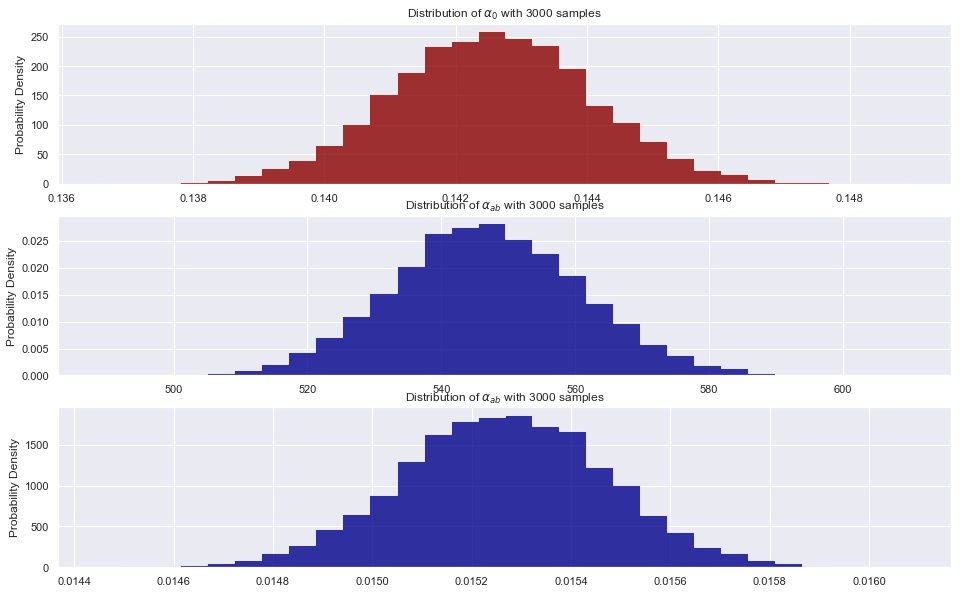

In [72]:
from IPython.core.pylabtools import figsize
figsize(16, 10)

plt.subplot(311)
plt.title(r"""Distribution of $\alpha_0$ with %d samples""" % N_SAMPLE)

plt.hist(alpha_samples, histtype='stepfilled', 
         color = 'darkred', bins=30, alpha=0.8, density=True);
plt.ylabel('Probability Density')


plt.subplot(312)
plt.title(r"""Distribution of $\kappa$ with %d samples""" % N_SAMPLE)
plt.hist(kappa_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

plt.subplot(313)
plt.title(r"""Distribution of $\alpha_{ab}$ with %d samples""" % N_SAMPLE)
plt.hist(mu_ab_samples, histtype='stepfilled', 
         color = 'darkblue', bins=30, alpha=0.8, density=True)
plt.ylabel('Probability Density');

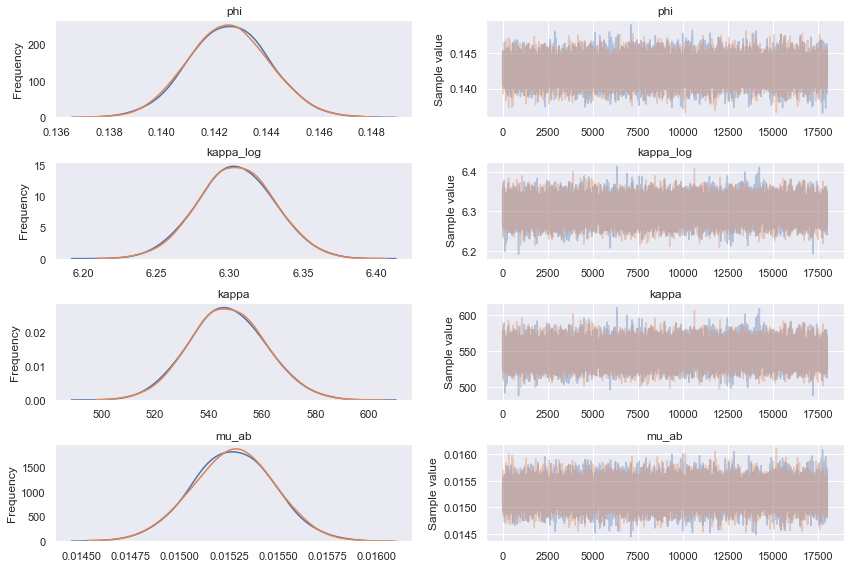

In [85]:
pm.traceplot(trace1[2000:]);

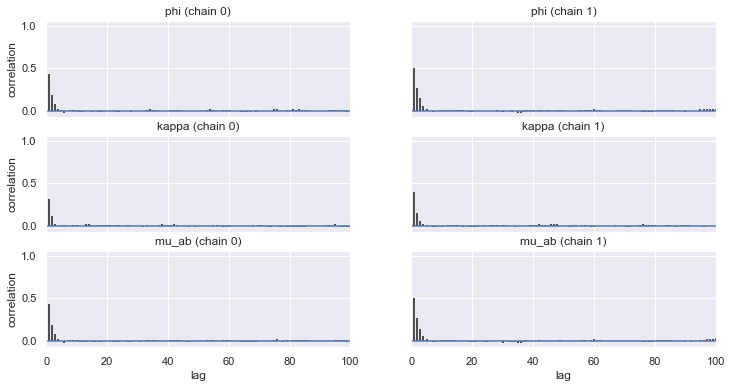

In [84]:
pm.autocorrplot(trace1[2000:], ['phi', 'kappa', "mu_ab"]);

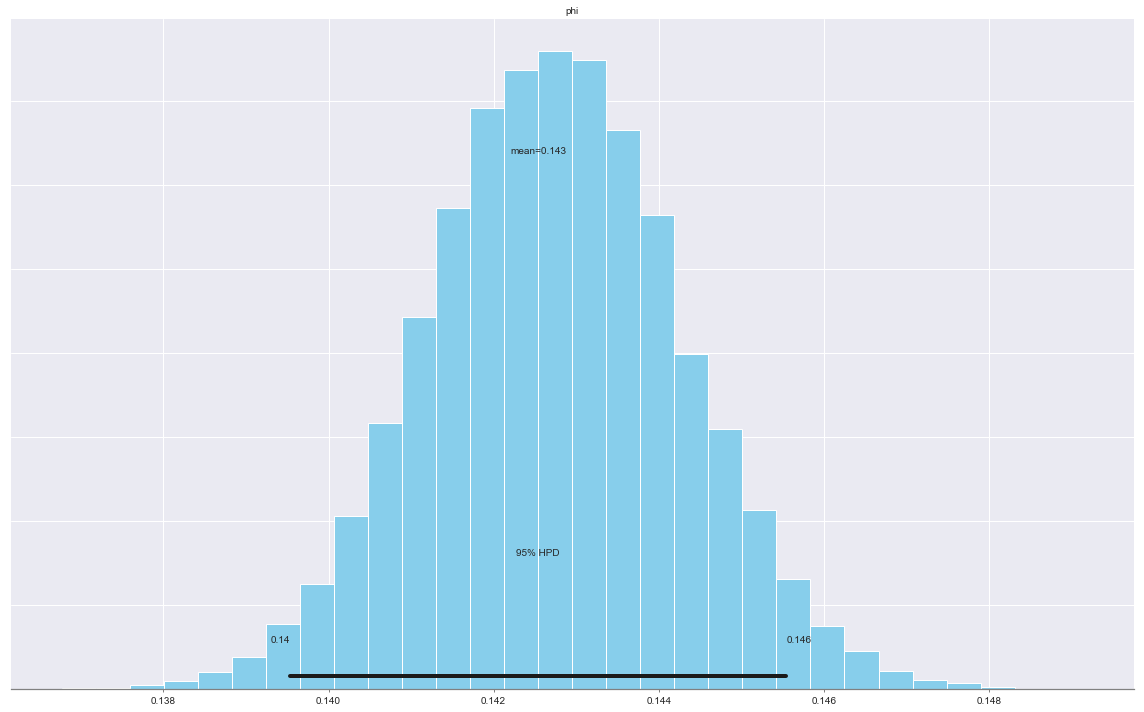

In [86]:
pm.plot_posterior(trace1[2000:], varnames=['phi']);

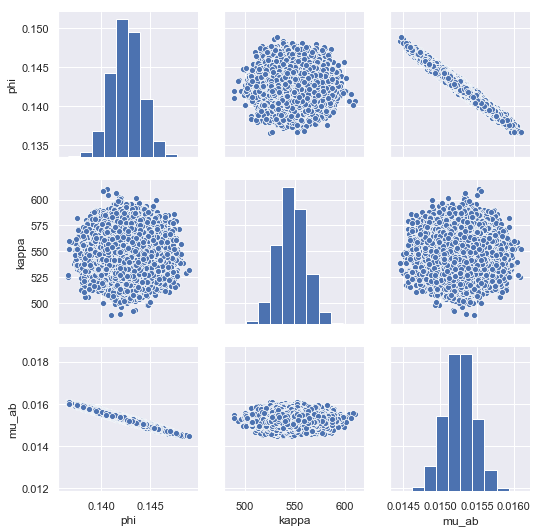

In [87]:
tracedf1 = pm.trace_to_dataframe(trace1[2000:], varnames=['phi', 'kappa', 'mu_ab'])
sns.pairplot(tracedf1);

We can calculate the Gelman Rubin statistic to evaluate the convergence of our MCMC chains:

In [ ]:
# https://colindcarroll.com/2018/01/01/bad-traces-or-dont-use-metropolis/
nuts_gr = pm.gelman_rubin(trace1, varnames=varnames)

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.bar(x=['phi','kappa','mu_ab'], height=nuts_gr.values());